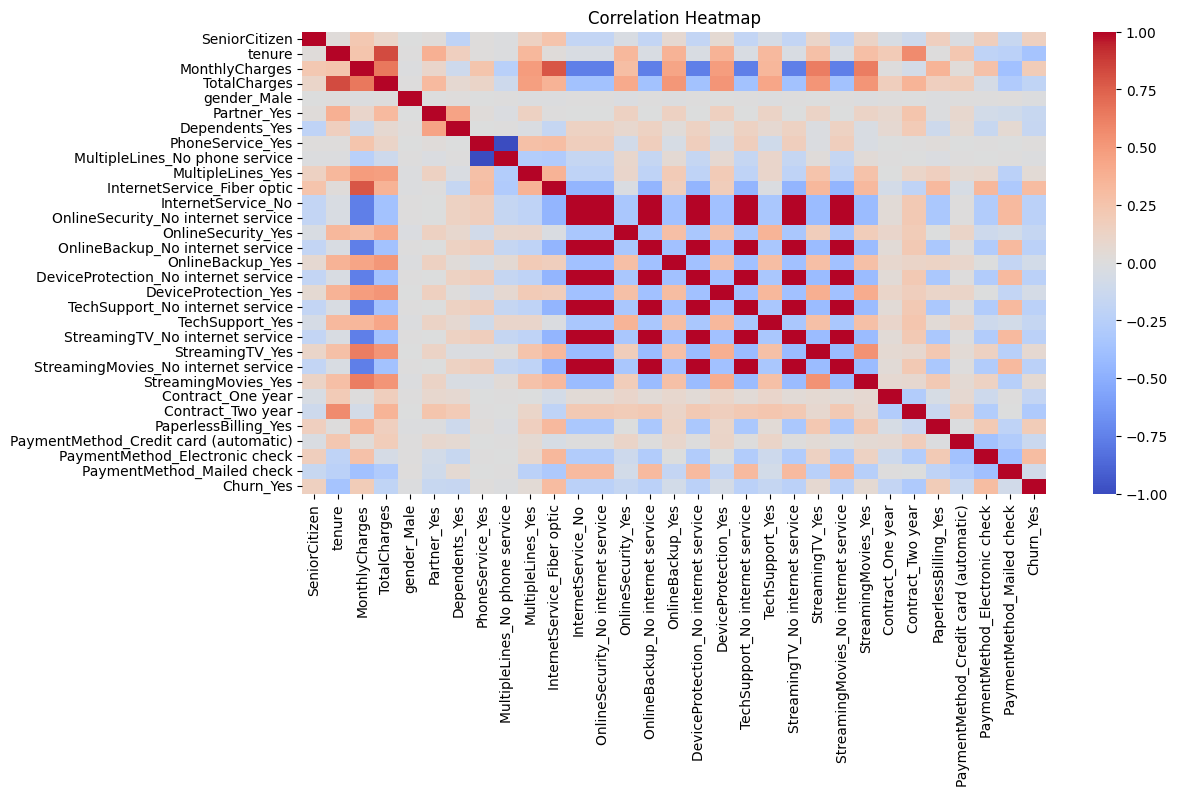

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

df = pd.read_csv('data/customer_churn.csv')

df.columns = df.columns.str.replace(' ', '')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.dropna(subset=['TotalCharges'])
df_encoded = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)
plt.figure(figsize=(12, 6))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

cols_to_drop = [
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service',
    'TotalCharges'
]

df_encoded = df_encoded.drop(columns=cols_to_drop)

X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

sm=SMOTE(random_state=42)
X, y=sm.fit_resample(X, y)


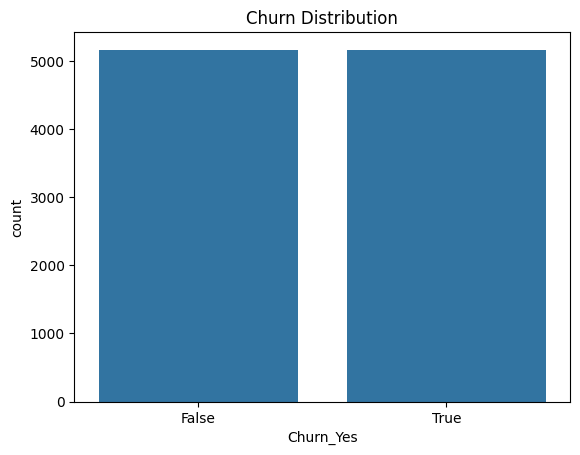

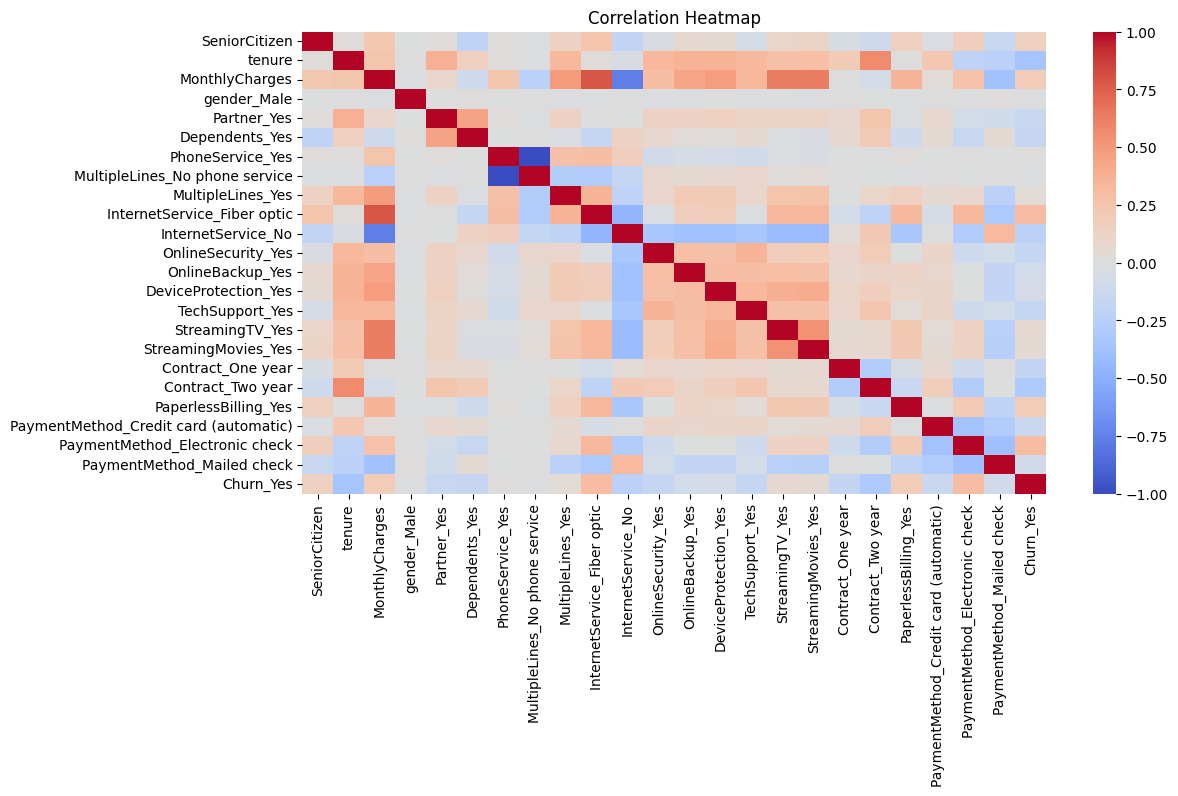

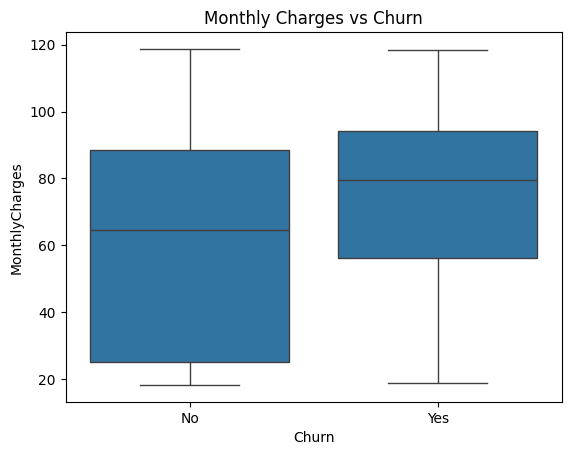

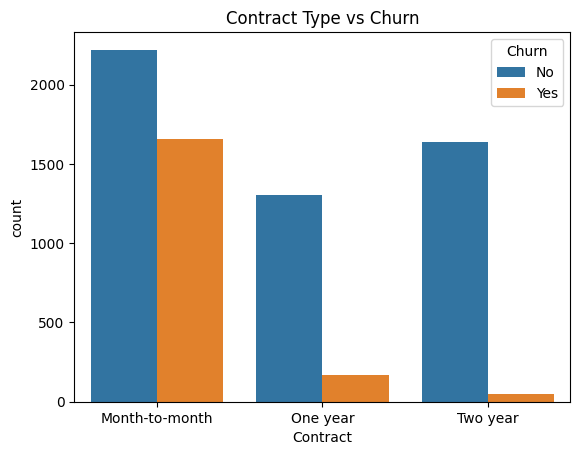

In [43]:
sns.countplot(x=y)
plt.title('Churn Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs Churn')
plt.show()


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

print("Gradient Boosting Results")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Results")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(accuracy_score(y_test, y_pred))


Gradient Boosting Results
              precision    recall  f1-score   support

       False       0.83      0.79      0.81      1037
        True       0.80      0.84      0.82      1029

    accuracy                           0.82      2066
   macro avg       0.82      0.82      0.82      2066
weighted avg       0.82      0.82      0.82      2066

[[824 213]
 [165 864]]
0.8170377541142304
Decision Tree Results
              precision    recall  f1-score   support

       False       0.81      0.81      0.81      1037
        True       0.80      0.81      0.80      1029

    accuracy                           0.81      2066
   macro avg       0.81      0.81      0.81      2066
weighted avg       0.81      0.81      0.81      2066

[[835 202]
 [200 829]]
0.8170377541142304


In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}


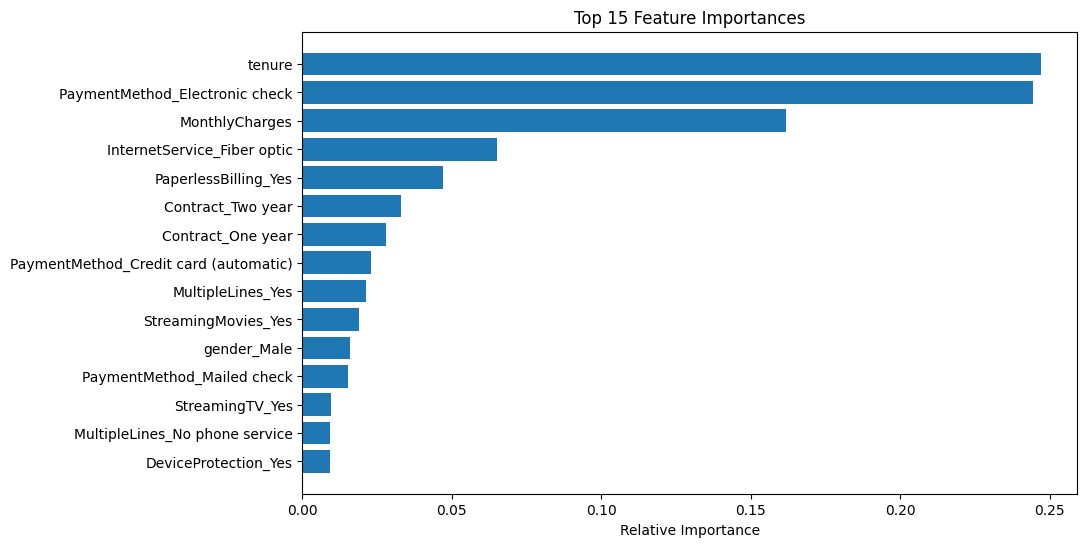

In [46]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(10, 6))
plt.title('Top 15 Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [49]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(**grid.best_params_)),
        ('dt', DecisionTreeClassifier())
    ],
    voting='soft'  # 'hard' for majority vote, 'soft' for average predicted probabilities
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

print("Voting Ensemble Results")
print(classification_report(y_test, y_pred_ensemble))
print(confusion_matrix(y_test, y_pred_ensemble))
print(accuracy_score(y_test, y_pred_ensemble))


Voting Ensemble Results
              precision    recall  f1-score   support

       False       0.80      0.81      0.80      1037
        True       0.80      0.80      0.80      1029

    accuracy                           0.80      2066
   macro avg       0.80      0.80      0.80      2066
weighted avg       0.80      0.80      0.80      2066

[[836 201]
 [206 823]]
0.8030009680542111


In [53]:
import joblib
joblib.dump(ensemble, 'churn_model.pkl')


['churn_model.pkl']